In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os 
import os.path
import cv2
import numpy as np
import matplotlib.pyplot as plt

**Reading in the data**

In [2]:

WORKING = 0
CRACK = 1
LCD = 2

CLASS_NUMBERS = [WORKING, CRACK, LCD]
CLASS_NAMES = ["Working", "Crack", "LCD"]

NUM_CLASSES = 3


     

In [3]:

def collect_file_paths(path: str, ext: str) -> list[str]:
    result = []
    
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            result.extend(collect_file_paths(item_path, ext))
        elif item_path.endswith(ext):
            result.append(item_path)
                
    return result

In [4]:
def images_to_array(image_paths: list[str], shrink_factor: int) -> np.ndarray:
    images = []
    
    for image_file in image_paths:
        image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        
        new_size = (
               int(image.shape[1] * shrink_factor / 100),
               int(image.shape[0] * shrink_factor / 100)
        )
        image = cv2.resize(image, dsize = new_size, interpolation = cv2.INTER_AREA)
        images.append(image)
        
    return np.array(images)

In [5]:
file_paths = collect_file_paths("images_for_model", ".jpeg")

input_filepaths = []
labels_list = []

for path in file_paths:
    file_name = path.split("/")[-1]
    labels = file_name.split("_")

    if not ("unknown" in labels):
        if "crack" in labels and "lcd" in labels:
            continue
        elif "crack" in labels:
            labels_list.append(CRACK)
        elif "lcd" in labels:
            labels_list.append(LCD)
        else:
            labels_list.append(WORKING)
        input_filepaths.append(path)
        
X = images_to_array(input_filepaths, 20)
y = np.array(labels_list)


In [6]:
NUM_SAMPLES = X.shape[0]
IMAGE_WIDTH = X.shape[1]
IMAGE_HEIGHT = X.shape[2]
IMAGE_SHAPE = (X.shape[1], X.shape[2], X.shape[3])

print("Entire dataset")
print("--------------")
print("Input shape: ", X.shape)
print("Output shape: ", y.shape)
print("Number of working phones: ", np.sum(y == WORKING))
print("Number of cracked phones: ", np.sum(y == CRACK))
print("Number of phones with damaged lcd: ", np.sum(y == LCD))
print("")


Entire dataset
--------------
Input shape:  (259, 806, 604, 3)
Output shape:  (259,)
Number of working phones:  136
Number of cracked phones:  107
Number of phones with damaged lcd:  16



**Preprocessing and stuff**

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=10, 
                             width_shift_range=0.1,     
                             height_shift_range=0.1,
                             zoom_range = [0.9, 1.1],
                             brightness_range=[0.7, 1.3],
                             horizontal_flip=True) 

2022-12-12 22:41:58.914303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 22:42:00.518321: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-12 22:42:14.676282: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/space/home/oliverpu/.conda/envs/condatest/lib/python3.10/site-packages/cv2/../../

In [10]:
gen_array=[]
lab_array=[]
for i in range(3):
    print(i)
    gen_imgs= datagen.flow(X_train, y_train, batch_size=150)
    X_gen, y_gen = gen_imgs.next()
    gen_array.append(X_gen)
    lab_array.append(y_gen)

0
1
2


In [11]:
gen_array.append(X_train)
lab_array.append(y_train)
X_train_gen=np.concatenate(np.array(gen_array))
y_train_gen=np.concatenate(np.array(lab_array))

/tmp/ipykernel_21869/2613952312.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_gen=np.concatenate(np.array(gen_array))
/tmp/ipykernel_21869/2613952312.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train_gen=np.concatenate(np.array(lab_array))


In [12]:
nsamples, nx, ny, nrgb = X_train_gen.shape
X_train_resh = X_train_gen.reshape(nsamples, nx*ny*nrgb)

nsamples_test, nx_test, ny_test, nrgb_test = X_test.shape
X_test_resh = X_test.reshape(nsamples_test, nx_test*ny_test*nrgb_test)

**Random Forest**

In [13]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [ ]:
#NB! This is only to get to optimal parameters. Takes a looong time.


#Result_list=[]
#Elements=[]
#for i in range(10, 1011, 100):
#    print("_____________________")
#    print(i)
#    Elements.append(i)
#    
#    RF = RandomForestClassifier(n_estimators= i)
#    RF.fit(X_train_resh, y_train_gen.ravel())
#    predicted=RF.predict(X_test_resh)
#    
#    acc=round(RF.score(X_test_resh, y_test), 5)
#    #print(f"Validation accuracy for {i} is {acc}%")
#    
#    recall=round(recall_score(y_test, predicted, average='macro'), 5)
#    #print(f"Recall score for {i} is {recall}")
#    
#    
#    f1=round(f1_score(y_test, predicted, average='macro'),5)
#    #print(f"F1 score for {i} is {f1}")
#    
#    Result_list.append([acc, recall, f1])


In [ ]:
#Dependent on the last point

#Accuracy = [sublist[0] for sublist in Result_list]
#Recall= [sublist[1] for sublist in Result_list]
#F1= [sublist[2] for sublist in Result_list]
#Average= [np.mean(sublist) for sublist in Result_list]
#opt_elements=Elements[np.argmax(Average)]

In [ ]:
#Dependent on the last point
#print("The best ones:")
#print("Accuracy", np.max(Accuracy), "at", Elements[np.argmax(Accuracy)])
#print("Recall", np.max(Recall), "at", Elements[np.argmax(Recall)])
#print("F1 score", np.max(F1), "at", Elements[np.argmax(F1)])
#print("The chosen one:", opt_elements)


In [14]:

opt_estimators=130

RF_optim = RandomForestClassifier(n_estimators= opt_estimators)
RF_optim.fit(X_train_resh, y_train_gen.ravel())


RandomForestClassifier(n_estimators=130)

In [15]:

predicted=RF_optim.predict(X_test_resh)
print(f"Accuracy at {opt_estimators} estimators is {round(RF_optim.score(X_test_resh, y_test)*100, 2)}% \nRecall is {round(recall_score(y_test, predicted, average='macro')*100, 2)}%\nF1 score is {round(f1_score(y_test, predicted, average='macro')*100,2)}%")
                                                                           

Accuracy at 130 estimators is 61.54% 
Recall is 42.11%
F1 score is 41.28%


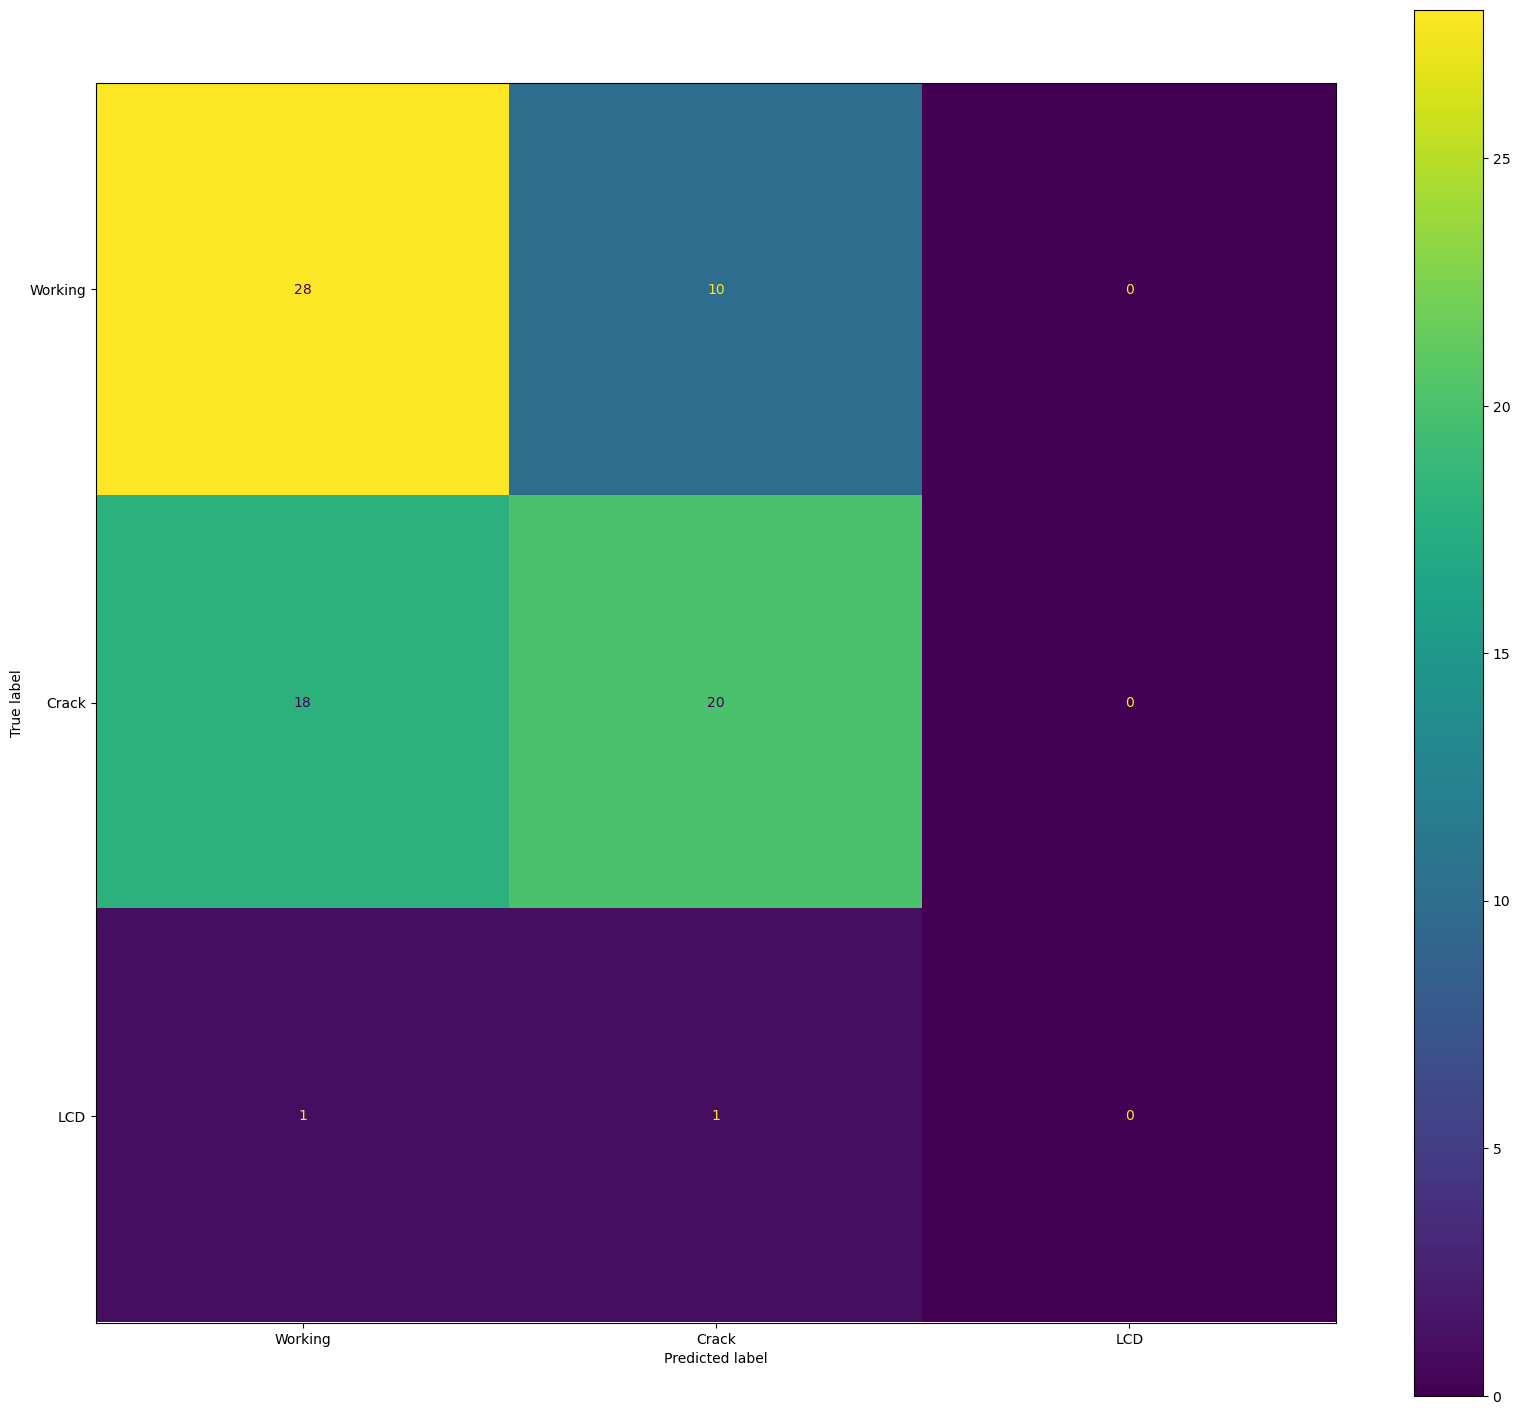

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

disp = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_test, predicted), 
        display_labels = CLASS_NAMES)
disp.plot()
plt.show()

**XGBoost**

In [20]:

import xgboost as xgb
import sklearn


/gpfs/space/home/oliverpu/.conda/envs/condatest/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [21]:

dtrain = xgb.DMatrix(X_train_resh, label=y_train_gen)
dtest = xgb.DMatrix(X_test_resh, label=y_test)


In [ ]:

#NB! This is only to get to optimal parameters. Takes a looong time.

#n_rounds = 300
#early_stopping = 4

#highsc=0
#nr=0

#eval_list = [(dtrain, "train"), (dtest, "validation")]

#scores=[]
#nr=[]

#for i in range(1, 42, 2):
#    print("_________")
#    print(i)
#    nr.append(i)
    
#    param_list = [("objective", "multi:softmax"), ("eval_metric", "merror"), ("num_class", 3), ("max_depth", i)]
#    bst = xgb.train(param_list, dtrain, n_rounds, evals=eval_list, early_stopping_rounds=early_stopping, verbose_eval=True)
#    ypred = bst.predict(dtest)
#    score=round(sklearn.metrics.accuracy_score(ypred, y_test)*100, 5)
#    scores.append(score)


#print("Different scores were:", scores)
#opt_choice=nr[np.argmax(scores)]
#print("Best accuracy was", np.max(scores),"at", opt_choice, "elements")


In [22]:
opt_choice= 15 #Untoggle this if you go through the long process

param_list = [("objective", "multi:softmax"), ("eval_metric", "mlogloss"), ("num_class", 3), ("max_depth", opt_choice)]

n_rounds = 600

early_stopping = 15
eval_list = [(dtrain, "train"), (dtest, "validation")]

bst = xgb.train(param_list, dtrain, n_rounds, evals=eval_list, early_stopping_rounds=early_stopping, verbose_eval=True)


[0]	train-mlogloss:0.89180	validation-mlogloss:1.05588
[1]	train-mlogloss:0.76532	validation-mlogloss:1.01808
[2]	train-mlogloss:0.67938	validation-mlogloss:0.99820
[3]	train-mlogloss:0.62063	validation-mlogloss:1.00534
[4]	train-mlogloss:0.57861	validation-mlogloss:1.00659
[5]	train-mlogloss:0.54961	validation-mlogloss:1.00955
[6]	train-mlogloss:0.52780	validation-mlogloss:1.00223
[7]	train-mlogloss:0.51171	validation-mlogloss:0.99138
[8]	train-mlogloss:0.49948	validation-mlogloss:1.00805
[9]	train-mlogloss:0.49029	validation-mlogloss:1.00227
[10]	train-mlogloss:0.48335	validation-mlogloss:1.01380
[11]	train-mlogloss:0.47793	validation-mlogloss:1.01977
[12]	train-mlogloss:0.47372	validation-mlogloss:1.02154
[13]	train-mlogloss:0.47044	validation-mlogloss:1.02226
[14]	train-mlogloss:0.46776	validation-mlogloss:1.02792
[15]	train-mlogloss:0.46569	validation-mlogloss:1.02626
[16]	train-mlogloss:0.46390	validation-mlogloss:1.03122
[17]	train-mlogloss:0.46258	validation-mlogloss:1.03312
[1

In [24]:

ypred = bst.predict(dtest)
print(f"Accuracy at depth {15} is {round(sklearn.metrics.accuracy_score(y_test, ypred)*100, 2)}% \nRecall is {round(recall_score(y_test, ypred, average='macro')*100, 2)}%\nF1 score is {round(f1_score(y_test, ypred, average='macro')*100,2)}%")
                                            

Accuracy at depth 15 is 48.72% 
Recall is 33.33%
F1 score is 27.9%


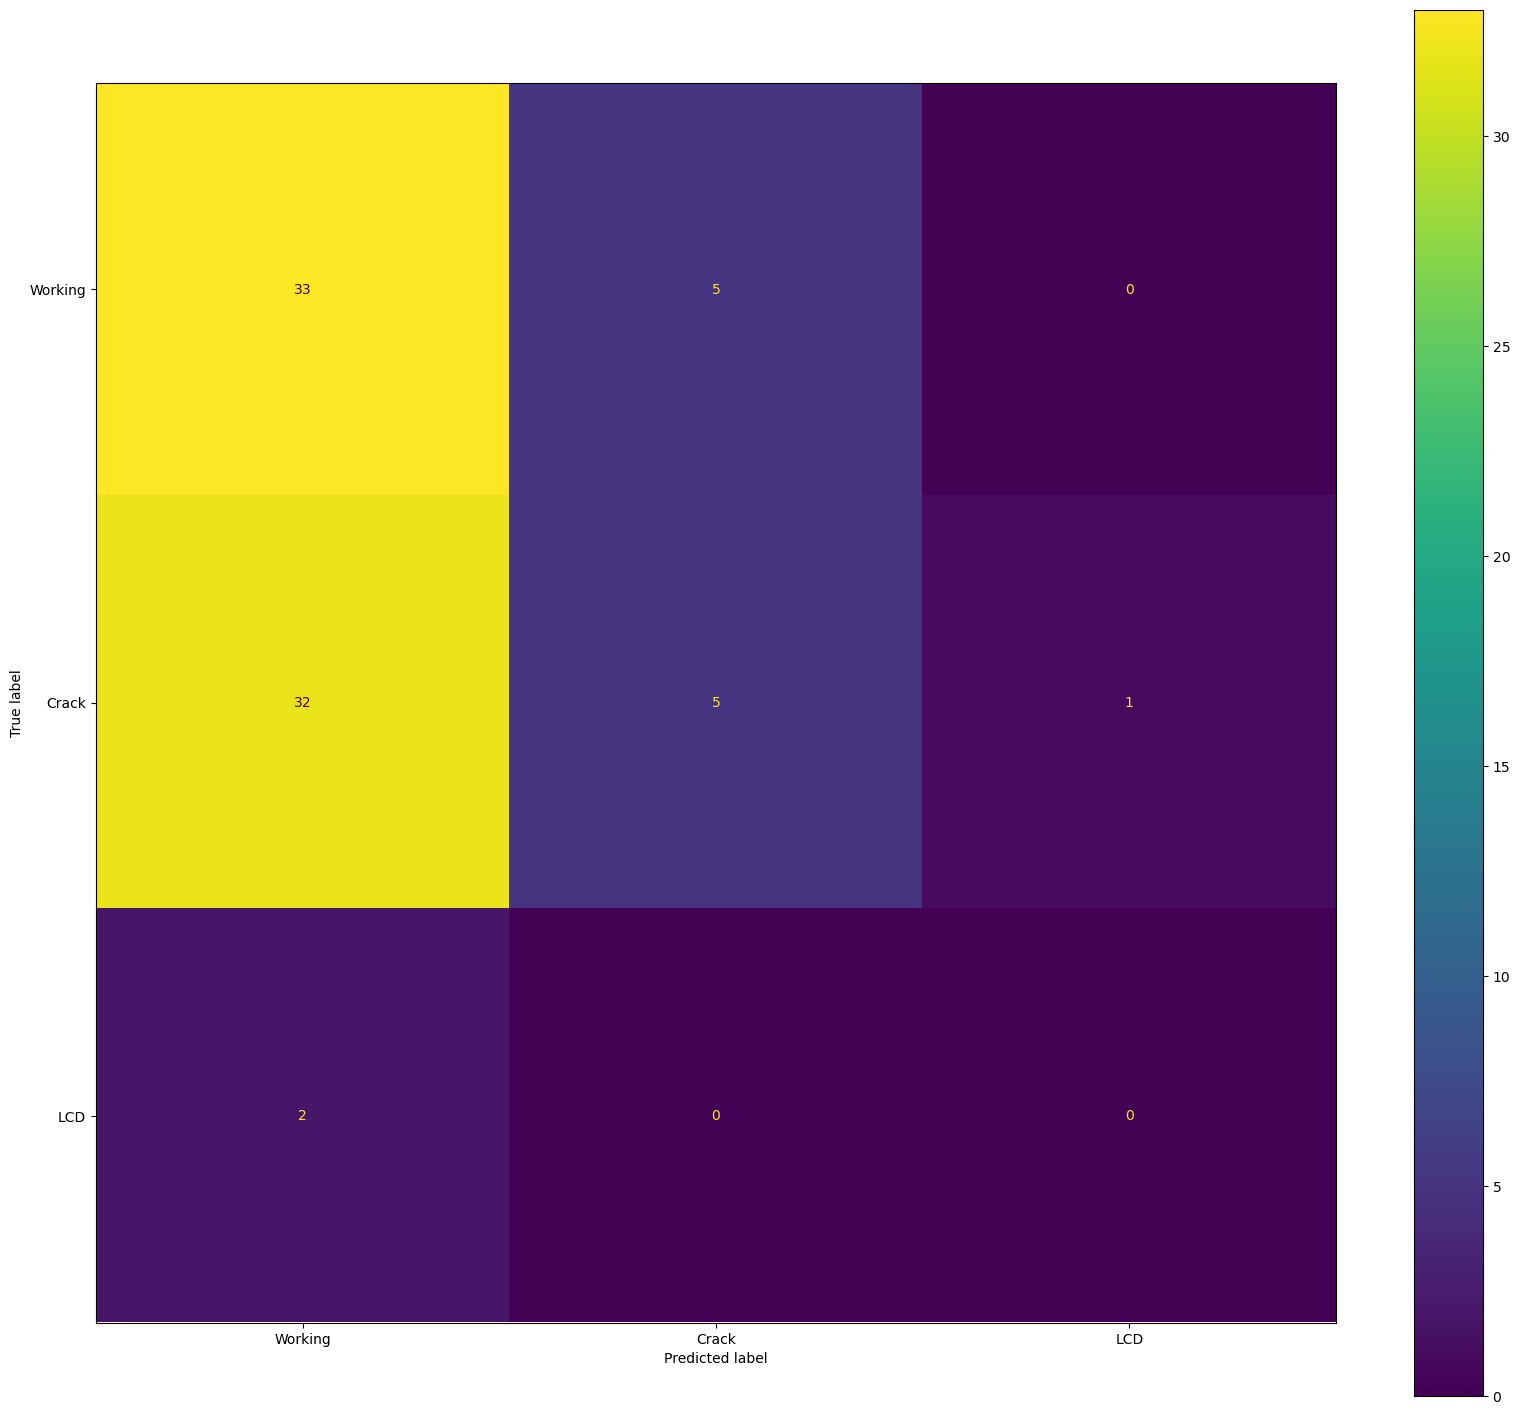

In [29]:
disp = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix(y_test, ypred), 
        display_labels = CLASS_NAMES)
disp.plot()
plt.show()
